In [1]:
# This enables auto-reloading of modules
%load_ext autoreload
%autoreload 2

# Import the model
from iris.src.chat_model.model import model

In [2]:
# Define conversation for testing
conversation = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant specialized in accounting."},
        {"role": "user", "content": "What is the definition of a business combination under IFRS, search internal wiki, perform 2 searches, just pick any documents"}
    ]
}

# You can modify the conversation above to test different scenarios

In [5]:
# Call the model function with our conversation and debug mode enabled
result_generator = model(conversation, debug_mode=True)

# Collect all response chunks and debug data
response_chunks = []
debug_data = None

for chunk in result_generator:
    # Check if this is debug data or a regular response chunk
    if chunk.startswith("\n\nDEBUG_DATA:"):
        debug_data_json = chunk.replace("\n\nDEBUG_DATA:", "")
        import json
        debug_data = json.loads(debug_data_json)
    else:
        response_chunks.append(chunk)
        print(chunk, end="", flush=True)

2025-04-04 17:20:56,585 - root - INFO - Logging system initialized
2025-04-04 17:20:56,586 - root - INFO - Initializing model setup...
2025-04-04 17:20:56,586 - iris.src.initial_setup.ssl.ssl - INFO - SSL certificate setup skipped in local environment
2025-04-04 17:20:56,587 - iris.src.initial_setup.oauth.oauth - INFO - Using API key authentication from local settings
2025-04-04 17:20:56,587 - iris.src.initial_setup.oauth.oauth - INFO - Using OpenAI API key from settings: sk-proj...
2025-04-04 17:20:56,587 - root - INFO - Processing input conversation...
2025-04-04 17:20:56,587 - iris.src.conversation_setup.conversation - INFO - Processed conversation: 2 messages filtered to 1 messages
2025-04-04 17:20:56,587 - root - INFO - Conversation processed: 1 messages
2025-04-04 17:20:56,587 - root - INFO - Getting routing decision...
2025-04-04 17:20:56,588 - iris.src.agents.agent_router.router - INFO - Getting routing decision using model: gpt-4o-mini-2024-07-18
2025-04-04 17:20:56,593 - iris

---
# 📋 Research Plan

## Research Statement
User requested a definition of a business combination under IFRS. This will involve searching the internal wiki for relevant documents that provide definitions and explanations related to business combinations. The search will focus on internal RBC-specific conclusions and guides regarding this accounting topic.

## Database Queries
1. APG Wiki Entries: Definition of business combination under IFRS
2. APG Wiki Entries: RBC-specific guidance on business combinations
---


## 🔍 Query 1: APG Wiki Entries - Definition of business combination under IFRS



2025-04-04 17:21:00,654 - iris.src.agents.database_subagents.database_router - INFO - Routing query to database: internal_wiki
2025-04-04 17:21:00,654 - iris.src.agents.database_subagents.internal_wiki.subagent - INFO - Querying Internal Wiki database: Definition of business combination under IFRS
2025-04-04 17:21:00,655 - iris.src.chat_model.model_settings - INFO - Using large model: gpt-4o-2024-08-06 in local environment
2025-04-04 17:21:00,655 - iris.src.agents.database_subagents.internal_wiki.subagent - INFO - Fetching wiki catalog with query: Definition of business combination under IFRS (environment: local)
2025-04-04 17:21:00,663 - iris.src.agents.database_subagents.internal_wiki.subagent - INFO - Retrieved 3 catalog entries from database
2025-04-04 17:21:00,664 - iris.src.agents.database_subagents.internal_wiki.subagent - INFO - Retrieved 3 catalog entries
2025-04-04 17:21:00,665 - iris.src.agents.database_subagents.internal_wiki.subagent - INFO - Selecting relevant documents f

No relevant documents found in the Internal Wiki database. Please try refining your query or check other databases.

---

2025-04-04 17:21:01,256 - root - INFO - Completed database query 1/2: internal_wiki
2025-04-04 17:21:01,256 - iris.src.agents.agent_judge.judge - INFO - Evaluating research progress using model: gpt-4o-mini-2024-07-18
2025-04-04 17:21:01,257 - iris.src.agents.agent_judge.judge - INFO - Completed queries: 1, Remaining queries: 1
2025-04-04 17:21:01,270 - iris.src.llm_connectors.rbc_openai - INFO - Using API key: sk-proj...
2025-04-04 17:21:01,270 - iris.src.llm_connectors.rbc_openai - INFO - Using API base URL: https://api.openai.com/v1
2025-04-04 17:21:01,271 - iris.src.llm_connectors.rbc_openai - INFO - Making non-streaming call to model: gpt-4o-mini-2024-07-18 with tools in local environment
2025-04-04 17:21:01,271 - iris.src.llm_connectors.rbc_openai - INFO - Attempt 1/3: Sending request to OpenAI API
2025-04-04 17:21:01,271 - iris.src.llm_connectors.rbc_openai - INFO - API call parameters (excluding message content): {'model': 'gpt-4o-mini-2024-07-18', 'max_tokens': 4096, 'temperat


## 📊 Research Summary


2025-04-04 17:21:02,274 - iris.src.agents.agent_summarizer.summarizer - INFO - Generating streaming research summary using model: gpt-4o-2024-08-06
2025-04-04 17:21:02,274 - iris.src.agents.agent_summarizer.summarizer - INFO - Summarizing 1 completed queries
2025-04-04 17:21:02,284 - iris.src.llm_connectors.rbc_openai - INFO - Using API key: sk-proj...
2025-04-04 17:21:02,285 - iris.src.llm_connectors.rbc_openai - INFO - Using API base URL: https://api.openai.com/v1
2025-04-04 17:21:02,285 - iris.src.llm_connectors.rbc_openai - INFO - Making streaming call to model: gpt-4o-2024-08-06 in local environment
2025-04-04 17:21:02,286 - iris.src.llm_connectors.rbc_openai - INFO - Attempt 1/3: Sending request to OpenAI API
2025-04-04 17:21:02,286 - iris.src.llm_connectors.rbc_openai - INFO - API call parameters (excluding message content): {'model': 'gpt-4o-2024-08-06', 'max_tokens': 4096, 'temperature': 0.1, 'stream': True, 'timeout': 30, 'stream_options': {'include_usage': True}}
2025-04-04 

## Key Findings

### Research Overview
The research aimed to define a business combination under IFRS, focusing on RBC-specific conclusions and guides available in the internal wiki database. However, the search did not yield any relevant documents from the internal wiki, indicating a gap in this specific internal resource for the requested topic.

### Database Query Results
- **Query 1**: Searched the `internal_wiki` for definitions and explanations related to business combinations under IFRS. Unfortunately, no relevant documents were found in this database.

### Considerations and Recommendations
- **Gap in Internal Resources**: The absence of relevant documents in the `internal_wiki` suggests that RBC-specific conclusions or guides on business combinations under IFRS may not be documented in this particular internal resource. This highlights a potential area for development within the internal knowledge base.
  
- **Alternative Databases**: Given the lack of results from the `intern

2025-04-04 17:21:08,561 - iris.src.llm_connectors.rbc_openai - INFO - Token usage - Completion: 392 ($0.0000), Prompt: 2260 ($0.0000), Total: 2652 tokens, Total Cost: $0.0000




---

## ⏸️ Remaining Queries

The following database queries were not processed:

**1.** APG Wiki Entries: RBC-specific guidance on business combinations


Please let me know if you would like to continue with these remaining database queries in a new search.

2025-04-04 17:21:08,563 - iris.src.agents.agent_summarizer.summarizer - INFO - Generating streaming research summary using model: gpt-4o-2024-08-06
2025-04-04 17:21:08,564 - iris.src.agents.agent_summarizer.summarizer - INFO - Summarizing 1 completed queries
2025-04-04 17:21:08,576 - iris.src.llm_connectors.rbc_openai - INFO - Using API key: sk-proj...
2025-04-04 17:21:08,577 - iris.src.llm_connectors.rbc_openai - INFO - Using API base URL: https://api.openai.com/v1
2025-04-04 17:21:08,578 - iris.src.llm_connectors.rbc_openai - INFO - Making streaming call to model: gpt-4o-2024-08-06 in local environment
2025-04-04 17:21:08,578 - iris.src.llm_connectors.rbc_openai - INFO - Attempt 1/3: Sending request to OpenAI API
2025-04-04 17:21:08,578 - iris.src.llm_connectors.rbc_openai - INFO - API call parameters (excluding message content): {'model': 'gpt-4o-2024-08-06', 'max_tokens': 4096, 'temperature': 0.1, 'stream': True, 'timeout': 30, 'stream_options': {'include_usage': True}}
2025-04-04 

## Key Findings

### Research Overview
The research aimed to define a business combination under IFRS, focusing on RBC-specific conclusions and guides within the internal wiki database. Unfortunately, the search did not yield any relevant documents from the internal wiki, indicating a gap in this specific database regarding the requested topic.

### Database Query Results
- **Query 1**: Searched the `internal_wiki` for a definition of a business combination under IFRS. No relevant documents were found.

### Interpretation and Recommendations
- **Gap in Internal Wiki**: The absence of relevant documents in the internal wiki suggests that this database may not contain specific entries or conclusions related to the definition of business combinations under IFRS. This highlights a potential area for future content development within the internal wiki to support RBC-specific interpretations and applications of IFRS standards.

- **Alternative Databases**: Given the lack of results from the 

2025-04-04 17:21:18,056 - iris.src.llm_connectors.rbc_openai - INFO - Token usage - Completion: 411 ($0.0000), Prompt: 2260 ($0.0000), Total: 2671 tokens, Total Cost: $0.0000




---
Completed 1 database queries.


2025-04-04 17:21:18,058 - root - INFO - Completed research process




---
## Agent Usage Statistics

- Input tokens: 2260
- Output tokens: 411
- Total tokens: 2671
- Cost: $0.000035
- Time: 21.47 seconds

### Database Subagent Usage

**APG Wiki Entries**
- Input tokens: 368
- Output tokens: 2
- Total tokens: 370
- Cost: $0.000001

### Overall Usage Statistics

- Overall Input tokens: 2628
- Overall Output tokens: 413
- Overall Total tokens: 3041
- Overall Cost: $0.000035


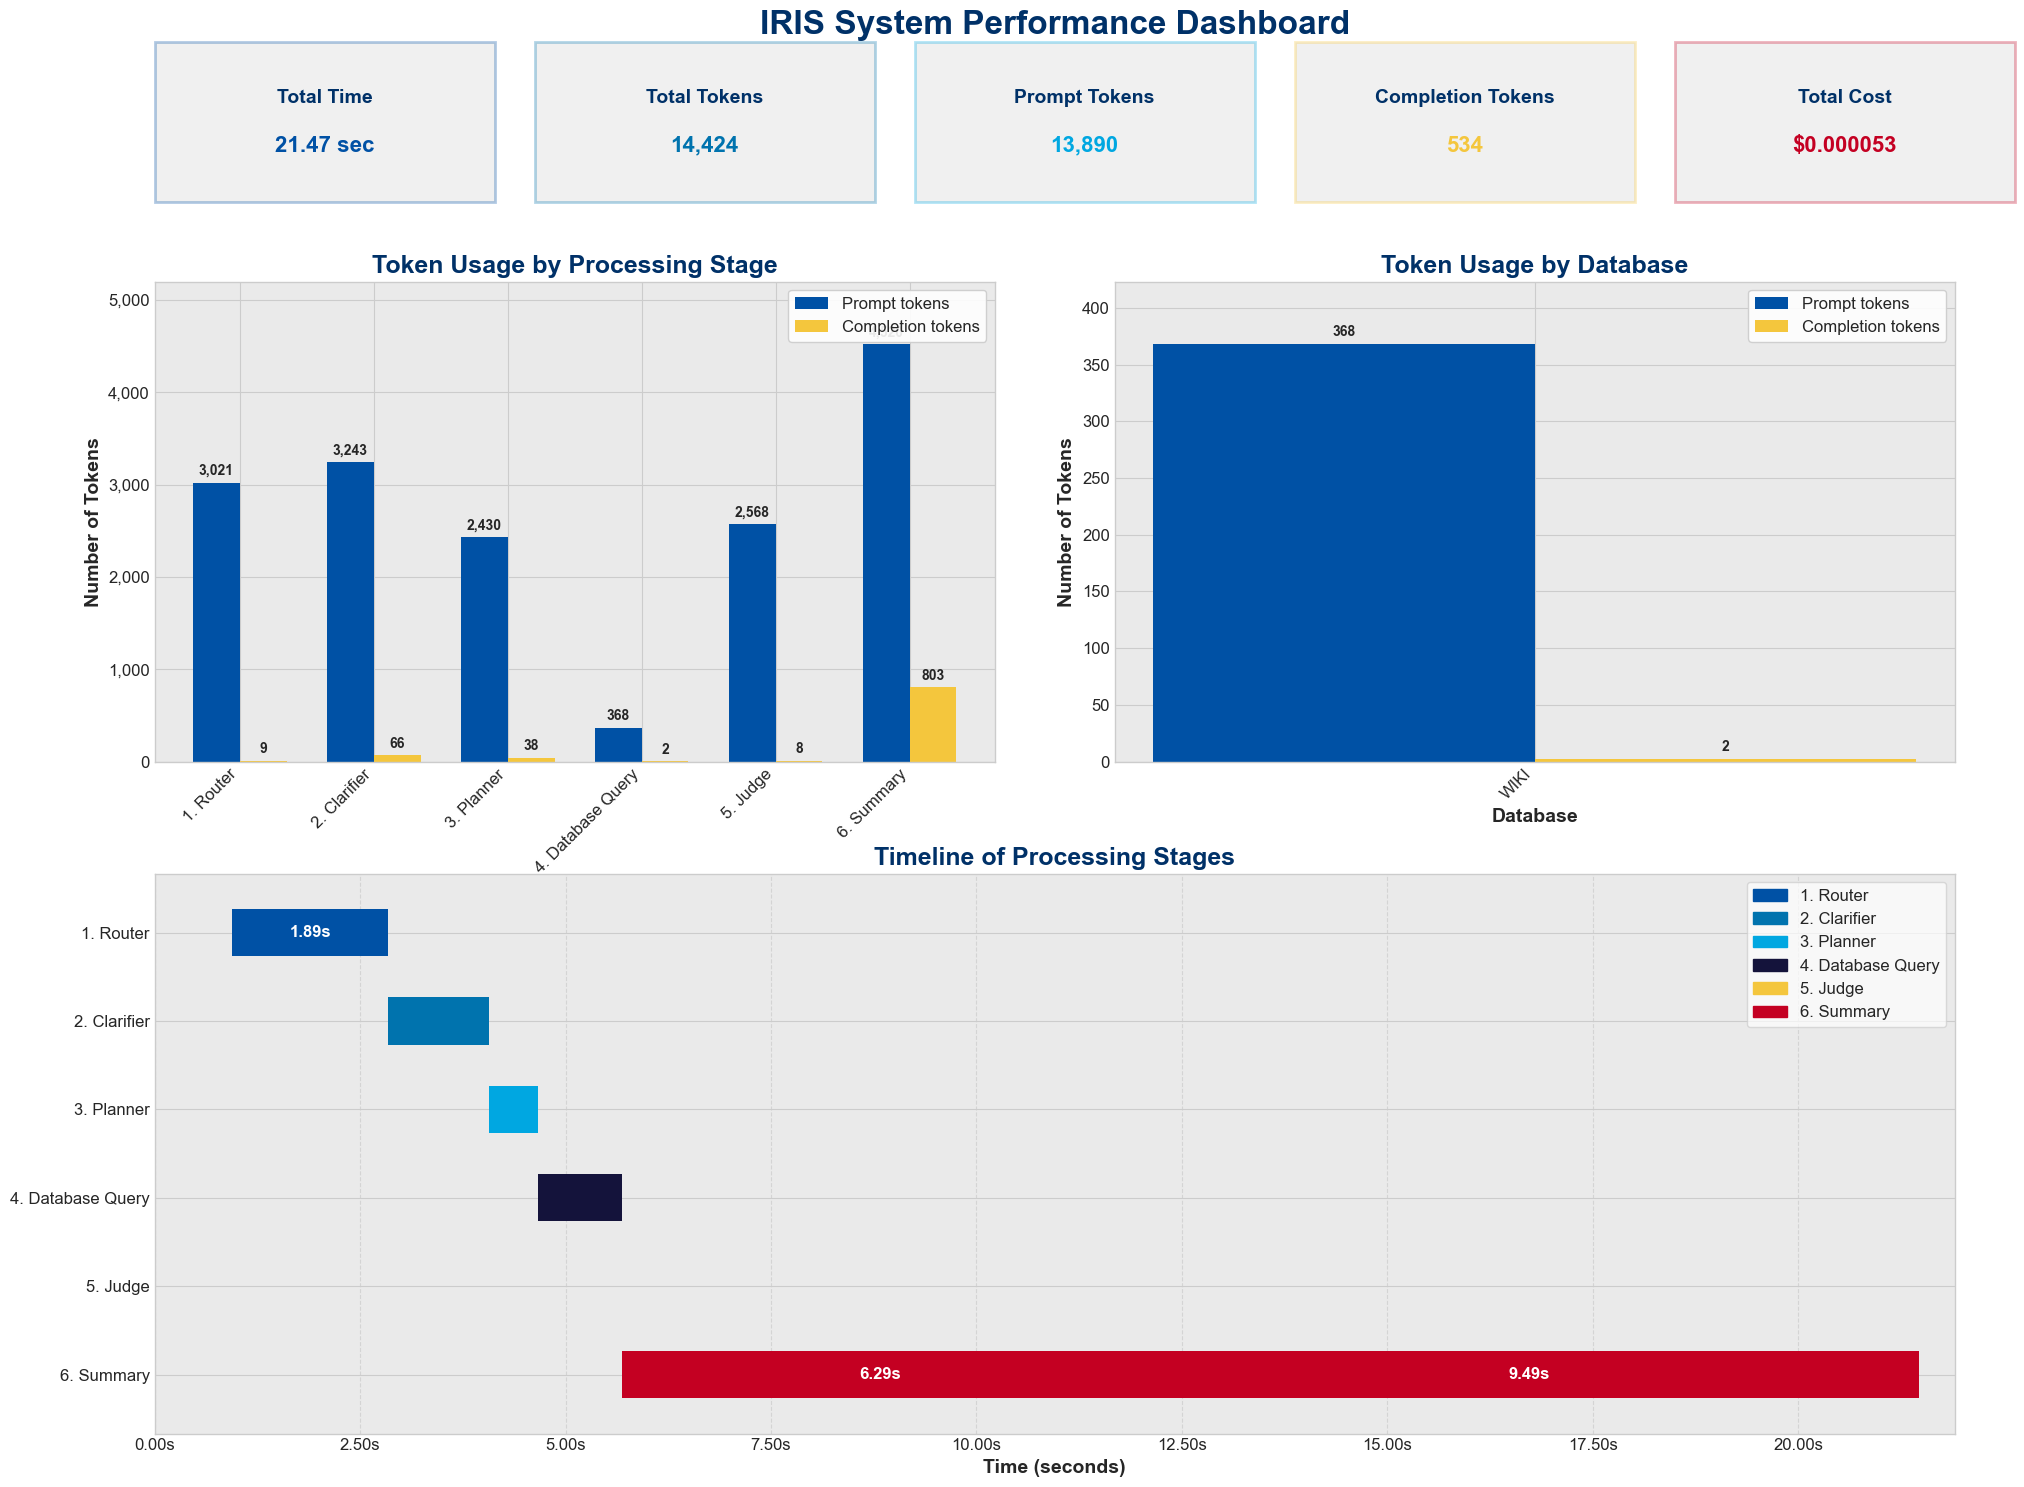

In [6]:
# Set up a widescreen dashboard visualization for process analytics and token usage
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

# RBC color theme
rbc_colors = {
    'primary_blue': '#0051A5',  # RBC Royal Blue
    'secondary_blue': '#0073AE', # RBC Secondary Blue
    'accent_blue': '#00A7E1',   # RBC Light Blue
    'dark_blue': '#003168',     # RBC Dark Blue
    'gold': '#F4C63D',          # RBC Gold
    'navy': '#14133B',          # RBC Navy
    'red': '#C40022',           # RBC Red
    'light_gray': '#EAEAEA',    # Light Gray for backgrounds
    'medium_gray': '#D0D0D0'    # Medium Gray for tile backgrounds
}

# Set the matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')

if debug_data:
    # Sort the decisions by timestamp to ensure correct ordering
    decisions_sorted = sorted(debug_data['decisions'], key=lambda x: datetime.fromisoformat(x['timestamp']))
    
    # Define stage order and display names
    stage_order = [
        'router',       # 1. Initial routing decision
        'clarifier',    # 2. Clarify research needs
        'planner',      # 3. Create query plan
        'database_query', # 4. Execute database queries
        'judge',        # 5. Evaluate research progress
        'summary'       # 6. Generate final summary
    ]
    
    # Better display names for stages
    stage_display_names = {
        'router': '1. Router',
        'clarifier': '2. Clarifier',
        'planner': '3. Planner',
        'database_query': '4. Database Query',
        'judge': '5. Judge',
        'summary': '6. Summary'
    }
    
    # Get the overall start and end times
    overall_start = datetime.fromisoformat(debug_data['start_timestamp'])
    overall_end = datetime.fromisoformat(debug_data['end_timestamp'])
    total_duration = (overall_end - overall_start).total_seconds()
    
    # Create dataframe from stage data
    stages_data = []
    for decision in decisions_sorted:
        stage = decision['stage']
        timestamp = datetime.fromisoformat(decision['timestamp'])
        if 'token_usage' in decision:
            token_usage = decision['token_usage']
            stages_data.append({
                'stage': stage,
                'display_name': stage_display_names.get(stage, stage),
                'timestamp': timestamp,
                'prompt_tokens': token_usage['prompt'],
                'completion_tokens': token_usage['completion'],
                'total_tokens': token_usage['total'],
                'cost': token_usage['cost']
            })
    
    # Create dataframe
    df_stages = pd.DataFrame(stages_data)
    
    # Calculate relative time from start
    df_stages['time_seconds'] = (df_stages['timestamp'] - overall_start).dt.total_seconds()
    
    # Group by stage and sum tokens
    stage_totals = df_stages.groupby(['stage', 'display_name']).agg({
        'prompt_tokens': 'sum',
        'completion_tokens': 'sum',
        'total_tokens': 'sum',
        'cost': 'sum'
    }).reset_index()
    
    # Sort by stage order
    stage_totals['stage_order'] = stage_totals['stage'].map({s: i for i, s in enumerate(stage_order)})
    stage_totals = stage_totals.sort_values('stage_order')
    
    # Create database data if available
    db_data = []
    if debug_data['tokens']['databases']:
        for db_name, usage in debug_data['tokens']['databases'].items():
            # Make display name more readable
            display_name = db_name.replace('internal_', '').replace('external_', '').upper()
            db_data.append({
                'database': db_name,
                'display_name': display_name,
                'prompt_tokens': usage['prompt_tokens'],
                'completion_tokens': usage['completion_tokens'],
                'total_tokens': usage['total_tokens'],
                'cost': usage['cost']
            })
        
        # Create dataframe
        df_db = pd.DataFrame(db_data)
    
    # Define colors for different stages
    stage_colors = {
        'router': rbc_colors['primary_blue'],
        'clarifier': rbc_colors['secondary_blue'],
        'planner': rbc_colors['accent_blue'],
        'database_query': rbc_colors['navy'],
        'judge': rbc_colors['gold'],
        'summary': rbc_colors['red']
    }
    
    # Create a clean dashboard layout
    fig = plt.figure(figsize=(20, 16))
    
    # Create top stats tiles - fixed layout
    # 1. Create a row of 5 tiles at the top - one for each stat and cost
    stat_tiles = [
        {"title": "Total Time", "value": f"{total_duration:.2f} sec", "color": rbc_colors['primary_blue']},
        {"title": "Total Tokens", "value": f"{debug_data['tokens']['total']:,}", "color": rbc_colors['secondary_blue']},
        {"title": "Prompt Tokens", "value": f"{debug_data['tokens']['prompt']:,}", "color": rbc_colors['accent_blue']},
        {"title": "Completion Tokens", "value": f"{debug_data['tokens']['completion']:,}", "color": rbc_colors['gold']},
        {"title": "Total Cost", "value": f"${debug_data['cost']:.6f}", "color": rbc_colors['red']}
    ]
    
    # Create a simple 3-row grid layout (stats row, token charts row, timeline row)
    # Create stats row - manually positioned rectangles 
    for i, stat in enumerate(stat_tiles):
        # Calculate position for each tile
        left = 0.05 + (i * 0.19)  # 5 tiles across the full width with small gaps
        bottom = 0.85
        width = 0.17
        height = 0.10
        
        # Create a rectangle for the tile
        rect = patches.Rectangle((left, bottom), width, height, 
                                linewidth=2, edgecolor=stat["color"],
                                facecolor=rbc_colors['medium_gray'], alpha=0.3)
        fig.add_artist(rect)
        
        # Add text directly to the figure
        fig.text(left + width/2, bottom + height*0.65, stat["title"], 
                ha='center', va='center', fontsize=14, fontweight='bold', 
                color=rbc_colors['dark_blue'])
        
        fig.text(left + width/2, bottom + height*0.35, stat["value"], 
                ha='center', va='center', fontsize=16, fontweight='bold',
                color=stat["color"])
    
    # Token Usage Charts Row - create two axes side by side
    ax_tokens = fig.add_axes([0.05, 0.5, 0.42, 0.3])  # [left, bottom, width, height]
    ax_db = fig.add_axes([0.53, 0.5, 0.42, 0.3])
    
    # Timeline row - larger chart at bottom
    ax_timeline = fig.add_axes([0.05, 0.08, 0.9, 0.35])
    
    # Add title at the top
    fig.text(0.5, 0.96, 'IRIS System Performance Dashboard', 
            ha='center', va='center', fontsize=24, fontweight='bold',
            color=rbc_colors['dark_blue'])
    
    # 1. Create the Token Usage by Stage chart
    bar_width = 0.35
    x = np.arange(len(stage_totals))
    
    # Plot bar chart with larger bars
    prompt_bars = ax_tokens.bar(x - bar_width/2, stage_totals['prompt_tokens'], bar_width, 
                         label='Prompt tokens', color=rbc_colors['primary_blue'])
    completion_bars = ax_tokens.bar(x + bar_width/2, stage_totals['completion_tokens'], bar_width, 
                             label='Completion tokens', color=rbc_colors['gold'])
    
    # Add value labels on top of bars
    for bars in [prompt_bars, completion_bars]:
        for bar in bars:
            height = bar.get_height()
            ax_tokens.text(bar.get_x() + bar.get_width()/2., height + 50,
                    f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax_tokens.set_xlabel('Processing Stage', fontsize=14, fontweight='bold')
    ax_tokens.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
    ax_tokens.set_title('Token Usage by Processing Stage', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
    ax_tokens.set_xticks(x)
    ax_tokens.set_xticklabels(stage_totals['display_name'], rotation=45, ha='right', fontsize=12)
    ax_tokens.tick_params(axis='y', labelsize=12)
    
    # Format y-axis with comma for thousands
    ax_tokens.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Add legend with better position
    ax_tokens.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
    
    # Set background color
    ax_tokens.set_facecolor(rbc_colors['light_gray'])
    
    # Add extra space at top for labels
    y_top = max([max(stage_totals['prompt_tokens']), max(stage_totals['completion_tokens'])]) * 1.15
    ax_tokens.set_ylim(0, y_top)
    
    # 2. Create the Database Usage chart
    if len(db_data) > 0:
        # Create a grouped bar chart
        x = np.arange(len(df_db))
        
        # Plot bar chart with larger bars
        prompt_bars = ax_db.bar(x - bar_width/2, df_db['prompt_tokens'], bar_width, 
                             label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_db.bar(x + bar_width/2, df_db['completion_tokens'], bar_width, 
                                 label='Completion tokens', color=rbc_colors['gold'])
        
        # Add value labels on top of bars
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                ax_db.text(bar.get_x() + bar.get_width()/2., height + 5,
                        f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax_db.set_xlabel('Database', fontsize=14, fontweight='bold')
        ax_db.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_db.set_title('Token Usage by Database', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_db.set_xticks(x)
        ax_db.set_xticklabels(df_db['display_name'], rotation=45, ha='right', fontsize=12)
        ax_db.tick_params(axis='y', labelsize=12)
        
        # Format y-axis with comma for thousands
        ax_db.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        
        # Add legend in a non-overlapping position
        ax_db.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        
        # Set background color
        ax_db.set_facecolor(rbc_colors['light_gray'])
        
        # Add extra space at top for labels
        y_top = max([max(df_db['prompt_tokens']), max(df_db['completion_tokens'])]) * 1.15
        ax_db.set_ylim(0, y_top)
    
    # 3. Create the Detailed Timeline Visualization
    # We need to keep ALL stage transitions in chronological order
    detailed_timeline = []
    
    for i, decision in enumerate(decisions_sorted):
        stage = decision['stage']
        timestamp = datetime.fromisoformat(decision['timestamp'])
        
        # End time is either the next decision's timestamp or the end timestamp
        if i + 1 < len(decisions_sorted):
            end_time = datetime.fromisoformat(decisions_sorted[i+1]['timestamp'])
        else:
            end_time = overall_end
        
        # Calculate relative times
        start_seconds = (timestamp - overall_start).total_seconds()
        end_seconds = (end_time - overall_start).total_seconds()
        duration = end_seconds - start_seconds
        
        # Add to detailed timeline
        detailed_timeline.append({
            'stage': stage,
            'display_name': stage_display_names.get(stage, stage),
            'start_seconds': start_seconds,
            'end_seconds': end_seconds,
            'duration': duration
        })
    
    # Create dataframe from detailed timeline
    df_detailed = pd.DataFrame(detailed_timeline)
    
    # Sort by start time to ensure chronological order
    df_detailed = df_detailed.sort_values('start_seconds')
    
    # Increase spacing between bars - MUCH larger height for visibility
    height = 0.8
    spacing = 1.5
    
    # Create a map of stage to positions (for consistent vertical position)
    unique_stages = list(stage_display_names.keys())
    stage_positions = {stage: i * spacing for i, stage in enumerate(reversed(unique_stages))}
    
    # Plot horizontal bars for each transition
    for i, row in df_detailed.iterrows():
        stage = row['stage']
        duration = row['duration']
        start_pos = row['start_seconds']
        duration_width = duration
        color = stage_colors.get(stage, 'gray')
        
        # Use the stage's consistent position
        position = stage_positions[stage]
        
        # Create the bar with proper position and width
        ax_timeline.barh(position, duration_width, left=start_pos, height=height, color=color)
        
        # Add text label for bars with sufficient width
        if duration_width > 1.5:
            text_pos = start_pos + duration_width/2
            label = f"{row['duration']:.2f}s"
            ax_timeline.text(text_pos, position, label, ha='center', va='center',
                    color='white', fontweight='bold', fontsize=12)
    
    # Adjust y-ticks and labels
    positions = list(stage_positions.values())
    stage_names = [stage_display_names[s] for s in reversed(unique_stages)]
    
    ax_timeline.set_yticks(positions)
    ax_timeline.set_yticklabels(stage_names, fontsize=12)
    
    ax_timeline.set_xlabel('Time (seconds)', fontsize=14, fontweight='bold')
    ax_timeline.set_title('Timeline of Processing Stages', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
    ax_timeline.tick_params(axis='x', labelsize=12)
    
    # Add gridlines and format x-axis with decimal places
    ax_timeline.grid(axis='x', linestyle='--', alpha=0.7)
    ax_timeline.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}s'))
    
    # Set background color
    ax_timeline.set_facecolor(rbc_colors['light_gray'])
    
    # Set appropriate x and y limits
    ax_timeline.set_xlim(0, total_duration * 1.02)  # Add a small margin
    ax_timeline.set_ylim(-1, max(positions) + 1)
    
    # Add legend for timeline stages 
    handles = [patches.Patch(color=color, label=stage_display_names.get(stage, stage)) 
              for stage, color in stage_colors.items()]
    ax_timeline.legend(handles=handles, loc='upper right', fontsize=12, frameon=True, framealpha=0.7)
    
    # Adjust figure layout
    plt.show()
else:
    print("No debug data available. Make sure to run with debug_mode=True.")